In [11]:
# ==== this should not be necessary - bug?
import sys

from dotenv import load_dotenv
from ldb_schema.paths import LocalPaths

sys.path.append('/home/johannes/ldb/ldb_wlexecutor/src/ldb_wlexecutor/analysis/benchmarks')
# ====

from dotenv import load_dotenv

load_dotenv()
from helper import preprocess_runs

path_name_dict = {
    # 'job': 'imdb_scaled1/benchmark_optimum_runs/job_full_w_optimal.json',
    'JOB-Light': 'imdb_scaled1/benchmark_optimum_runs/job_light_w_optimal_w_idxs.json',
    # 'job_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_full_w_optimal_w_idxs.json',
    'JOB': 'imdb_scaled1/join_order_job_w_idxs_combined.json',
    # 'job_extended_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_extended_v20250426_w_optimal_w_idxs.json',
    # 'job_extended_w_idxs_combined': 'imdb_scaled1/join_order_JOBExtended_v20250426._combined.json',
    # 'job_extended2_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_extended_v20250509_w_optimal_w_idxs.json',
    # 'JOB-Extended.old': 'imdb_scaled1/JOBExtended_selection1.old.json',
    'JOB-Extended': 'imdb_scaled1/JOBExtended_selection1.json',
    'JOB-Extended (b)': 'imdb_scaled1/JOBExtended_selection1b.json',
}
benchmark_stats_dict = preprocess_runs(LocalPaths().Data.json_plans,path_name_dict)

Loading run files from /mnt/c/PhD/ldb/ldb_data/runs/json
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:00<00:00, 197711.30it/s]


Benchmark: JOB (37085 plans)


Cleaning SQL: 100%|██████████| 37085/37085 [00:00<00:00, 178793.37it/s]


Benchmark: JOB-Extended (15805 plans)


Cleaning SQL: 100%|██████████| 15805/15805 [00:00<00:00, 321174.09it/s]


Benchmark: JOB-Extended (b) (15805 plans)


Cleaning SQL: 100%|██████████| 15805/15805 [00:00<00:00, 240659.91it/s]


# Speedup Analysis: Postgres vs. Optimum

70
113
30
30
Benchmark           Num Queries    Total Opt Runtime (s)    Total PG Runtime (s)    Total Speedup    Median Speedup    Median Diff (s)    PG Best Plan Selected (%)    Speedup 90th percentile
----------------  -------------  -----------------------  ----------------------  ---------------  ----------------  -----------------  ---------------------------  -------------------------
JOB-Light                    70                  2359.72                 2795.53             1.18           1.00208               0.51                        40                       1.45408
JOB                         113                   156.79                  312.23             1.99           1.28699              88                            8.85                    5.11035
JOB-Extended                 30                    54.17                  567.01            10.47           8.50421           10654.2                          0                      83.6684
JOB-Extended (b)             30  

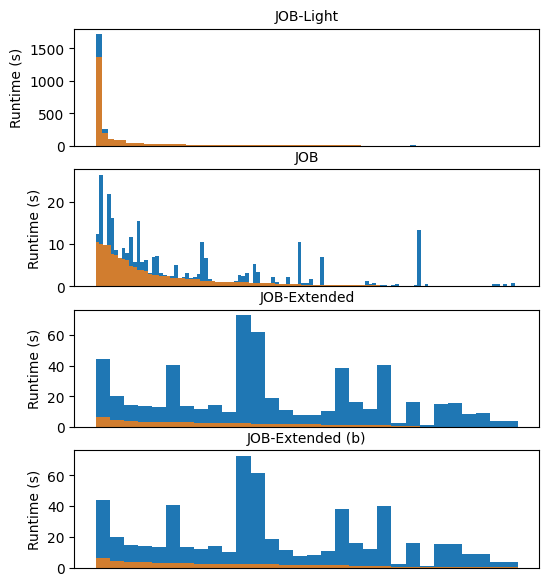

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def create_runtime_plot(df, benchmark_name: str, max=None, ax=None, show_legend=True, bbox_to_anchor=None):
    opt_runtimes = df['optimal']
    pg_runtimes = df['pg']
    q_ids = df['q_id']

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sorted_opt_runtimes = sorted(opt_runtimes, reverse=True)
    sorted_pg_runtimes = [x for _, x in sorted(zip(opt_runtimes, pg_runtimes), reverse=True)]
    sorted_qids = [str(x) for _, x in sorted(zip(opt_runtimes, q_ids), reverse=True)]

    ax.bar(sorted_qids, sorted_pg_runtimes, label='PG Runtimes', width=1)
    ax.bar(sorted_qids, sorted_opt_runtimes, label='Opt Runtimes', alpha=0.8, width=1)
    # plt.title(f'Opt / PG Runtimes ({benchmark_name})')
    if show_legend:
        ax.legend(frameon=False, loc='upper right', bbox_to_anchor=bbox_to_anchor, ncols=2)

    ax.set_title(f'{benchmark_name}', fontsize=10)
    # ax.set_xlabel(f'{len(sorted_pg_runtimes)} {benchmark_name} Queries')
    ax.set_ylabel('Runtime (s)')
    # plt.yscale('log')

    # hide xtick labels
    ax.set_xticks([])

    # if benchmark_name == 'job_extended_w_idxs' and max is None:
    #     max = 100

    if max is not None:
        ax.set_ylim(0, max)


fig, axs = plt.subplots(len(benchmark_stats_dict), 1, figsize=(6, 1.75 * len(benchmark_stats_dict)))

cleanup_pg_opt_mismatch = True

tabulate_list = []
id_to_sql_dict = defaultdict(dict)
for i, (benchmark_name, info) in enumerate(benchmark_stats_dict.items()):
    optimal_runtimes = []
    pg_runtimes = []
    q_ids = []
    speedup_list = []
    diff_list = []
    pg_best_plan_selected = []

    for id, (sql, plan_info) in enumerate(info.items()):
        opt_rt = plan_info['opt_runtime']
        pg_rt = plan_info['pg_runtime']

        if opt_rt is None or pg_rt is None:
            print(f'Skip because of null: {opt_rt} / {pg_rt}')
            continue

        # convert to seconds
        opt_rt = opt_rt / 1000
        pg_rt = pg_rt / 1000

        if cleanup_pg_opt_mismatch and opt_rt > pg_rt:
            opt_rt = pg_rt

        q_ids.append(id)
        optimal_runtimes.append(opt_rt)
        pg_runtimes.append(pg_rt)
        id_to_sql_dict[benchmark_name][id] = (sql, opt_rt, pg_rt, plan_info['opt_hint'])

        speedup_list.append(plan_info['pg_slowdown'])
        diff_list.append(plan_info['pg_opt_diff'])

        pg_best_plan_selected.append(opt_rt == pg_rt)

    # convert to df (two columns)
    df = pd.DataFrame({'optimal': optimal_runtimes, 'pg': pg_runtimes, 'q_id': q_ids,
                       'speedup': speedup_list, 'diff': diff_list})
    print(len(optimal_runtimes))

    # add to list
    tabulate_list.append([benchmark_name, len(info), f"{sum(df['optimal']):.2f}", f"{sum(df['pg']):.2f}",
                          f"{sum(df['pg']) / sum(df['optimal']):.2f}", f"{np.median(df['speedup'])}",
                          f"{np.median(df['diff']):.2f}",
                          f'{sum(pg_best_plan_selected) / len(pg_best_plan_selected) * 100:.2f}',
                          np.percentile(df['speedup'], 90)])

    create_runtime_plot(df, benchmark_name=benchmark_name, max=None, ax=axs[i], show_legend=i == 2,
                        bbox_to_anchor=(0.85, -.09))

import tabulate

print(tabulate.tabulate(tabulate_list,
                        headers=['Benchmark', 'Num Queries', 'Total Opt Runtime (s)', 'Total PG Runtime (s)',
                                 'Total Speedup', 'Median Speedup', 'Median Diff (s)', 'PG Best Plan Selected (%)',
                                 'Speedup 90th percentile'])) \
 \
# save figure
plt.savefig('/mnt/c/Users/Johannes/Downloads/speedups.pdf', bbox_inches='tight', dpi=300, transparent=False)


In [13]:
id_to_sql_dict['job_extended_w_idxs'][83]

KeyError: 83

In [ ]:
sql = list(benchmark_stats_dict['job_extended_w_idxs_v2'].keys())

print(len(sql))

string = ''
for s in sql:
    string += f'{s}\n'

print(string)